<a href="https://colab.research.google.com/github/Kadeian/reimagined-octo-disco/blob/master/CIFAR13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# B. Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten


In [9]:
# C. Load the CIFAR-10 dataset
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [10]:
# D
def adaptive_recursive_compress(images, y_labels, base_iterations=2, threshold=0.01):
    compressed_images = images.copy()
    prev_loss = None
    best_compressed = None
    best_iterations = base_iterations
    iterations = base_iterations

    for i in range(5):  # Max 5 recursive attempts
        # Check spatial dims
        if compressed_images.shape[1] < 4 or compressed_images.shape[2] < 4:
            break

        # Apply compression on each RGB channel
        compressed_images = (
            compressed_images[:, ::2, ::2, :] +
            compressed_images[:, 1::2, ::2, :] +
            compressed_images[:, ::2, 1::2, :] +
            compressed_images[:, 1::2, 1::2, :]
        ) / 4

        # Resize back to (32, 32, 3)
        resized = tf.image.resize(compressed_images, (32, 32)).numpy()

        # Simulate model training
        temp_model = build_model(input_shape=(32, 32, 3), num_classes=10)
        history = temp_model.fit(resized, y_labels, epochs=1, validation_split=0.1, verbose=0)
        loss = history.history['loss'][-1]

        if prev_loss is not None and abs(prev_loss - loss) < threshold:
            break  # Stop compressing if change is too small

        best_compressed = resized
        best_iterations = iterations
        prev_loss = loss
        iterations += 1

    return best_compressed, best_iterations


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense

# F. Define Neural Network Model (Flexible for Any Input Shape)
def build_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential([
        Input(shape=input_shape),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
# G. Train Models and Display Accuracy Results

# Train model on raw CIFAR-10 data
model_raw = build_model()
history_raw = model_raw.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=2)

# Train model on adaptively compressed CIFAR-10 data
compressed_x_train, iters_train = adaptive_recursive_compress(x_train, y_train)
compressed_x_test, iters_test = adaptive_recursive_compress(x_test, y_test)

model_adaptive = build_model()
history_adaptive = model_adaptive.fit(compressed_x_train, y_train, epochs=5, validation_data=(compressed_x_test, y_test), verbose=2)

# Print final accuracies
print(f"Final Accuracy - Raw Data Model: {history_raw.history['val_accuracy'][-1]:.4f}")
print(f"Final Accuracy - Adaptive RDC Model: {history_adaptive.history['val_accuracy'][-1]:.4f}")
print(f"AI chose {iters_train} iterations for training and {iters_test} for testing.")


Epoch 1/5
1563/1563 - 16s - 10ms/step - accuracy: 0.3265 - loss: 1.8656 - val_accuracy: 0.3904 - val_loss: 1.7088
Epoch 2/5
1563/1563 - 14s - 9ms/step - accuracy: 0.3952 - loss: 1.6895 - val_accuracy: 0.4236 - val_loss: 1.6224
Epoch 3/5
1563/1563 - 20s - 13ms/step - accuracy: 0.4253 - loss: 1.6042 - val_accuracy: 0.4378 - val_loss: 1.5626
Epoch 4/5
1563/1563 - 14s - 9ms/step - accuracy: 0.4435 - loss: 1.5531 - val_accuracy: 0.4516 - val_loss: 1.5375
Epoch 5/5
1563/1563 - 21s - 13ms/step - accuracy: 0.4589 - loss: 1.5191 - val_accuracy: 0.4602 - val_loss: 1.5201
Epoch 1/5
1563/1563 - 16s - 10ms/step - accuracy: 0.2314 - loss: 2.0470 - val_accuracy: 0.2768 - val_loss: 1.9602
Epoch 2/5
1563/1563 - 16s - 10ms/step - accuracy: 0.2686 - loss: 1.9665 - val_accuracy: 0.2959 - val_loss: 1.9251
Epoch 3/5
1563/1563 - 14s - 9ms/step - accuracy: 0.2824 - loss: 1.9409 - val_accuracy: 0.2969 - val_loss: 1.9082
Epoch 4/5
1563/1563 - 14s - 9ms/step - accuracy: 0.2898 - loss: 1.9219 - val_accuracy: 0.29

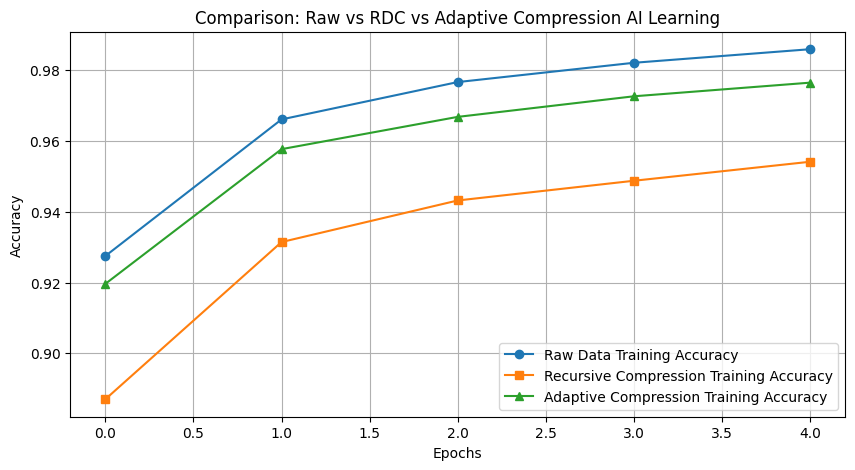

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_raw.history['accuracy'], label='Raw Data Training Accuracy', marker='o')
plt.plot(history_rdc.history['accuracy'], label='Recursive Compression Training Accuracy', marker='s')
plt.plot(history_adaptive.history['accuracy'], label='Adaptive Compression Training Accuracy', marker='^')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Comparison: Raw vs RDC vs Adaptive Compression AI Learning")
plt.legend()
plt.grid()
plt.show()
